In [ ]:
import pims
import trackpy as tp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.filters import try_all_threshold
from skimage.filters import threshold_mean, threshold_yen, threshold_local
from sklearn.cluster import DBSCAN
from skimage.morphology import skeletonize, binary_dilation

## To do: 
- ~~read image~~
- ~~thresholding to find DNA molecules~~
- ~~clustering to sort mask into individual DNA pieces~~
    - ~~remove small objects that are not DNA~~
- ~~find a curve that best describes each DNA molecule~~
    - ~~skeletonisation~~
    - ~~curve fitting~~
- ~~track the DNAs across timepoints~~
- analysis of DNA properties across time

#### Things I messed up: 
- the xs and ys are swapped throughout this jupyter, damn you imshow for using a weird convention

In [438]:
dummy_number = 10000

### Read image

In [365]:
#path = '/Users/szalapak/Projects/IMPRS_PhdCourse_2021/C2-20nMFUS_GFP_10nMSyO_50mMNaCl_BSA001.tif'
path = '/Users/szalapak/Projects/IMPRS_PhdCourse_2021/microscopy_files/C2-100nM_Sox2_Cherry_0_2nM_Sox2_GFP_OxScv_ShutClos20_488_003_DNA.tif'

frames = pims.open(path)

In [366]:
image = frames[0]

Frame([[276, 199, 245, ..., 188, 131, 144],
       [254, 215, 181, ..., 177, 126, 177],
       [292, 256, 229, ..., 135, 144, 203],
       ...,
       [117, 123, 126, ..., 133, 159, 189],
       [121, 123, 110, ..., 179, 120, 198],
       [120, 106, 147, ..., 101, 155, 119]], dtype=uint16)
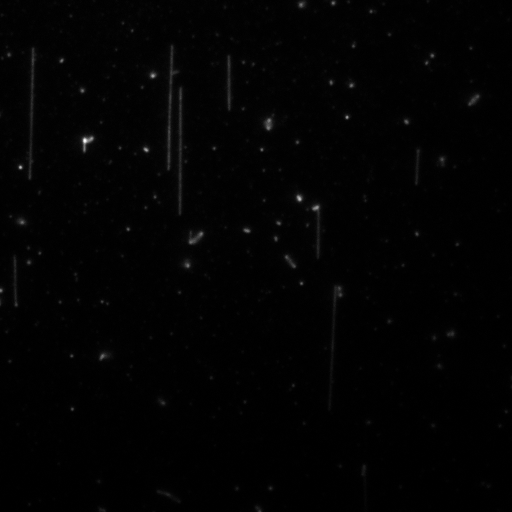

In [367]:
image

### Possible approaches: 

1. Thresholding -> clustering -> removing small objects -> line fitting
2. 

### Thresholding

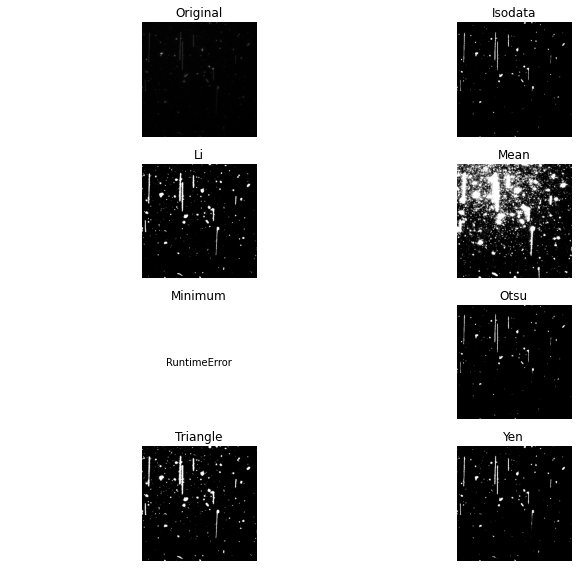

In [368]:
fig, ax = try_all_threshold(image, figsize=(10, 8), verbose=False)
plt.show()

(0.0, 2000.0)

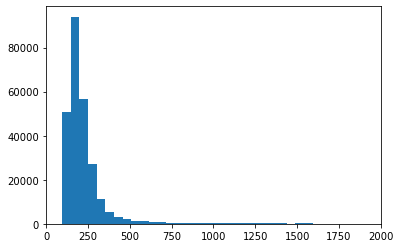

In [369]:
plt.hist(np.array(image).ravel(), bins=256)
#plt.axvline(thresh_min, color='r')

plt.xlim(0,2000)

In [377]:
from skimage.filters import threshold_li, threshold_triangle

In [379]:
global_thresh = threshold_mean(image)
binary_mean = image > global_thresh

yen_thresh = threshold_yen(image)
binary_yen = image > yen_thresh

li_thresh = threshold_li(image)
binary_li = image > li_thresh

triangle_thresh = threshold_triangle(image)
binary_triangle = image > triangle_thresh

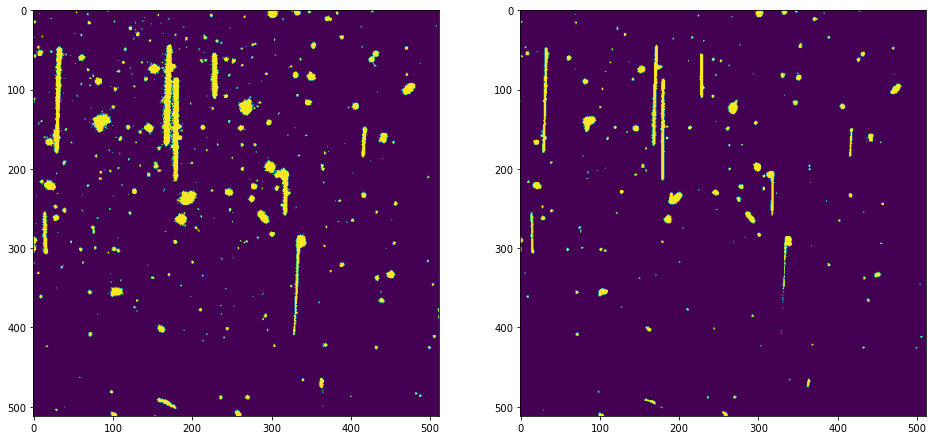

In [421]:
fig, axs = plt.subplots(1,2, figsize = (16, 8))

axs[0].imshow(binary_triangle)
axs[1].imshow(binary_yen)

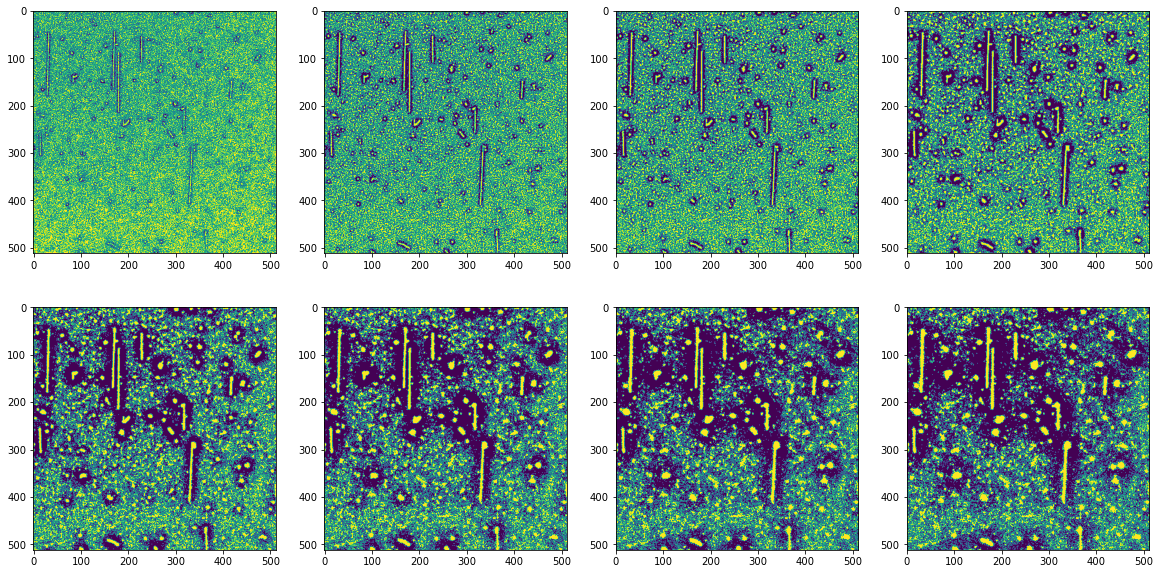

In [372]:
sizes = [5,11,15,25,45,65,85,101]

fig, axs = plt.subplots(2, int(len(sizes)/2), figsize = (5*len(sizes)/2, 5*2))

for i, block_size in enumerate(sizes): 
    
    a = int(i%(len(sizes)/2))
    b = int(i/(len(sizes)/2))

    adaptive_thresh = threshold_local(image, block_size, offset=10)
    binary_adaptive = image > adaptive_thresh
    
    axs[b, a].imshow(binary_adaptive)
    

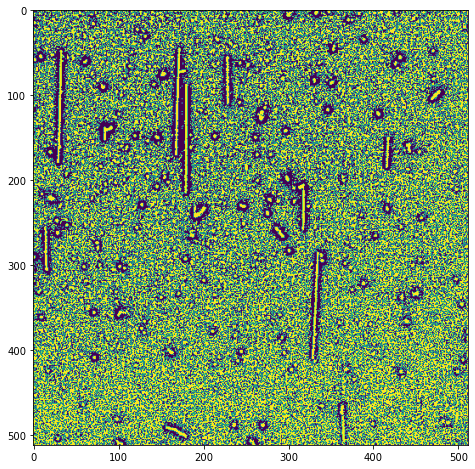

In [381]:
block_size = 11
adaptive_thresh = threshold_local(image, block_size, offset=10)
binary_adaptive = image > adaptive_thresh

plt.figure(figsize = (8,8))
plt.imshow(binary_adaptive)

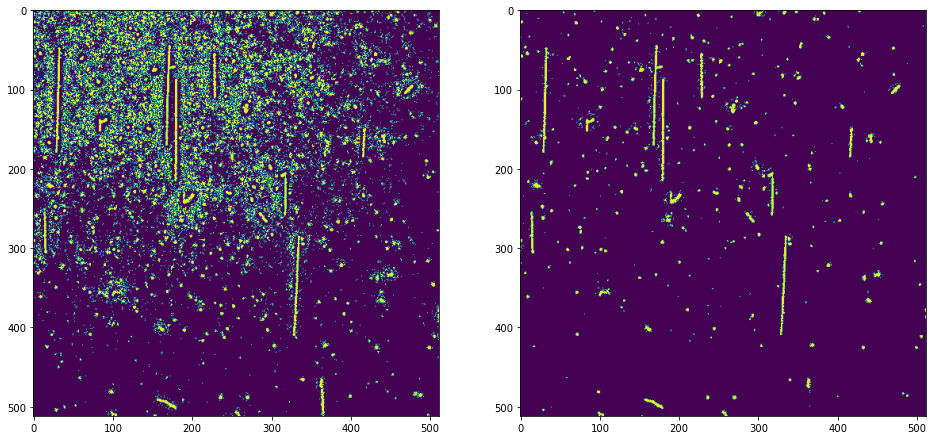

In [383]:
fig, axs = plt.subplots(1,2, figsize = (16, 8))

axs[0].imshow(np.array(binary_adaptive) & np.array(binary_mean))

axs[1].imshow(np.array(binary_adaptive) & np.array(binary_triangle))

In [398]:
#thresholded_im = np.array(binary_adaptive) & np.array(binary_mean)
thresholded_im = np.array(binary_adaptive) & np.array(binary_triangle)

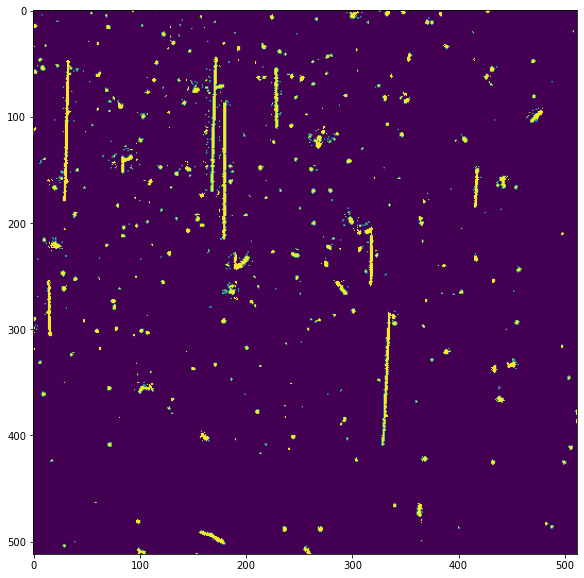

In [399]:
plt.figure(figsize = (10,10))

plt.imshow(thresholded_im)

In [400]:
xs, ys = np.where(thresholded_im)

coords = np.vstack((xs, ys)).T

In [401]:
clusters = DBSCAN(eps=1, min_samples=2).fit(coords)
cluster_labels = clusters.labels_ + 1

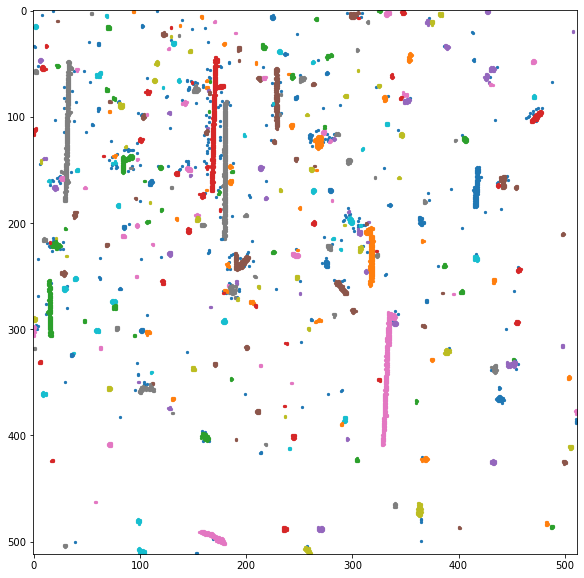

In [402]:
zeros = np.zeros(thresholded_im.shape)

plt.figure(figsize = (10, 10))

plt.imshow(zeros, cmap=plt.cm.binary)

for label in np.unique(cluster_labels):
    
    plt.scatter(coords[(cluster_labels == label)][:,1], coords[(cluster_labels == label)][:,0], s = 5)

In [403]:
cluster_size_threshold = 75

#could also add thresholding by checking that the cluster is much taller than it is wide

big_cluster_labels = []
big_cluster_coords = []

i = 0

for label in np.unique(cluster_labels)[1:]:
    if len(cluster_labels[cluster_labels == label]) >= cluster_size_threshold:
        
        big_cluster_labels.extend([i for n in range(len(cluster_labels[cluster_labels == label]))])
        big_cluster_coords.extend(coords[cluster_labels == label])
        
        i += 1

        
big_cluster_labels = np.array(big_cluster_labels)
big_cluster_coords = np.array(big_cluster_coords)

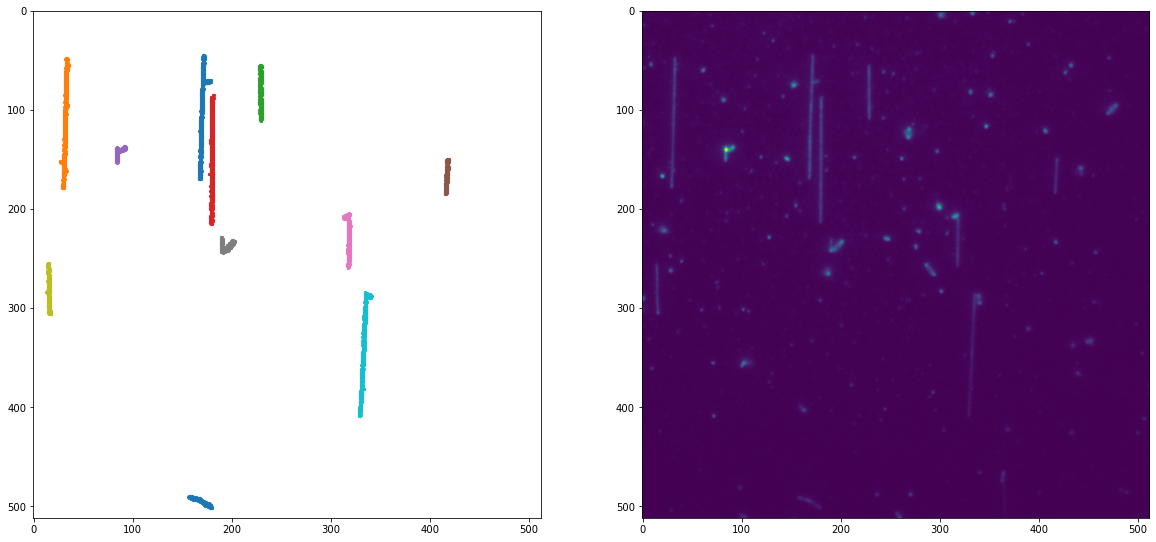

In [404]:
zeros = np.zeros(thresholded_im.shape)

fig, axs = plt.subplots(1,2, figsize = (20, 10))

axs[0].imshow(zeros, cmap=plt.cm.binary)

for label in np.unique(big_cluster_labels):
    
    axs[0].scatter(big_cluster_coords[(big_cluster_labels == label)][:,1], 
                big_cluster_coords[(big_cluster_labels == label)][:,0], 
                s = 5)
    
axs[1].imshow(image)

### Data structures: Make a dictionary with all the DNA fragments

In [405]:
DNA_dict = {}


for label in np.unique(big_cluster_labels):
    DNA_dict[label] = {'coords' : big_cluster_coords[(big_cluster_labels == label)]}

In [406]:
#make image mask with DNA cluster labels at the places of DNA fragments

image_label_mask = np.zeros(image.shape)

image_label_mask += dummy_number

for i, coord in enumerate(big_cluster_coords):
    
    image_label_mask[coord[0], coord[1]] = big_cluster_labels[i]

### Skeletonisation

In [408]:
def fit_polynomial(xs, ys):
    
    #if the range of values of ys is larger than in xs, 
    #fit xs to ys rather than the other way round
    switch_coords = None
    
    if  max(ys) - min(ys) > max(xs) - min(xs):
        orig_ys = ys.copy()
        orig_xs = xs.copy()
        
        ys = orig_xs.copy()
        xs = orig_ys.copy()
        
        switch_coords = True
        
    sorted_x = np.sort(xs + (np.random.random(len(xs)) / 100))
    sorted_y = ys[np.argsort(xs)]
    
    pol_params = np.polyfit(sorted_x, sorted_y, 3)

    poly_y = pol_params[0]*sorted_x**3 + pol_params[1]*sorted_x**2 + pol_params[2]*sorted_x + pol_params[3]
    
    if switch_coords: 
        fitted_x = poly_y
        fitted_y = sorted_x
        
    else: 
        
        fitted_x = sorted_x
        fitted_y = poly_y
    
    return fitted_x, fitted_y

#### Test the skeletonisation vs polynomial fit

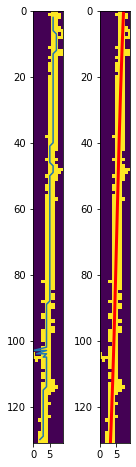

In [409]:
label = 1

xs = DNA_dict[label]['coords'][:,1]
ys = DNA_dict[label]['coords'][:,0]

y_min = min(ys)
x_min = min(xs)

y_max = max(ys)
x_max = max(xs)

x_range = x_max - x_min
y_range = y_max - y_min

#extract fragment of the image corresponding to a DNA fragment
#and change labels to 1s and 0s
DNA_frag_mask = np.where(image_label_mask[y_min:y_max, x_min:x_max] == 10000, 0, 1)


fig, axs = plt.subplots(1,2, 
                        figsize = (2*x_range/min(x_range, y_range), 2*int(y_range/min(x_range, y_range))))

axs[0].imshow(DNA_frag_mask)

skeleton_mask = binary_dilation(DNA_frag_mask)
skeletonised = skeletonize(skeleton_mask)

ys_skeleton, xs_skeleton = np.where(skeletonised)

axs[0].plot(xs_skeleton, ys_skeleton)

axs[1].imshow(DNA_frag_mask)

#could also be worth to fit polynomial to the binary dilation? 
sorted_x, poly_y =  fit_polynomial(DNA_dict[label]['coords'][:,1], DNA_dict[label]['coords'][:,0])

axs[1].plot(sorted_x - x_min,
            poly_y - y_min,
         c = 'r', lw = 3)

custom_ylim = (y_max - y_min - 1, y_min - y_min)
custom_xlim = (x_min - x_min, x_max - x_min - 1)

plt.setp(axs, xlim=custom_xlim, ylim=custom_ylim)
fig.tight_layout()


#axs[1].scatter(xs, smooth(ys,5))

#### Get the skeletonised and polynomial coordinates and add them to our dictionary

In [410]:
for label in DNA_dict.keys():
    
    xs = DNA_dict[label]['coords'][:,1]
    ys = DNA_dict[label]['coords'][:,0]

    y_min = min(ys)
    x_min = min(xs)

    y_max = max(ys)
    x_max = max(xs)

    x_range = x_max - x_min
    y_range = y_max - y_min
    
    offset = 3
    
    #skeletonised_coords: 
    skeleton_mask = np.where(image_label_mask[y_min-offset:y_max+offset, x_min-offset:x_max+offset] == label, 1, 0)
    for i in range(offset - 1): 
        skeleton_mask = binary_dilation(skeleton_mask)
        
    skeletonised = skeletonize(skeleton_mask)
    ys_skeleton, xs_skeleton = np.where(skeletonised)
    
    ys_skeleton += y_min - offset
    xs_skeleton += x_min - offset
    
    skeletonised_coords =  np.vstack((ys_skeleton, xs_skeleton)).T
    DNA_dict[label]['skeletonised_coords'] = skeletonised_coords
    
    #polynomial_coords
    sorted_x, poly_y =  fit_polynomial(DNA_dict[label]['coords'][:,1], DNA_dict[label]['coords'][:,0])
    polynomial_coords = np.vstack((poly_y, sorted_x)).T
    DNA_dict[label]['polynomial_coords'] = polynomial_coords

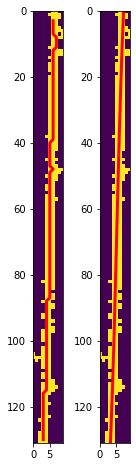

In [413]:
label = 1

xs = DNA_dict[label]['coords'][:,1]
ys = DNA_dict[label]['coords'][:,0]

y_min = min(ys)
x_min = min(xs)

y_max = max(ys)
x_max = max(xs)

x_range = x_max - x_min
y_range = y_max - y_min

#extract fragment of the image corresponding to a DNA fragment
#and change labels to 1s and 0s
DNA_frag_mask = np.where(image_label_mask[y_min:y_max, x_min:x_max] == label, 1, 0)


fig, axs = plt.subplots(1,2, 
                        figsize = (2*x_range/min(x_range, y_range), 2*int(y_range/min(x_range, y_range))))

axs[0].imshow(DNA_frag_mask)

axs[0].plot(DNA_dict[label]['skeletonised_coords'][:,1] - x_min, 
            DNA_dict[label]['skeletonised_coords'][:,0] - y_min, 
           c = 'r', lw = 3)

axs[1].imshow(DNA_frag_mask)

axs[1].plot(DNA_dict[label]['polynomial_coords'][:,1] - x_min, 
            DNA_dict[label]['polynomial_coords'][:,0] - y_min, 
           c = 'r', lw = 3)

custom_ylim = (y_max - y_min - 1, y_min - y_min)
custom_xlim = (x_min - x_min, x_max - x_min - 1)

plt.setp(axs, xlim=custom_xlim, ylim=custom_ylim)
fig.tight_layout()


#axs[1].scatter(xs, smooth(ys,5))

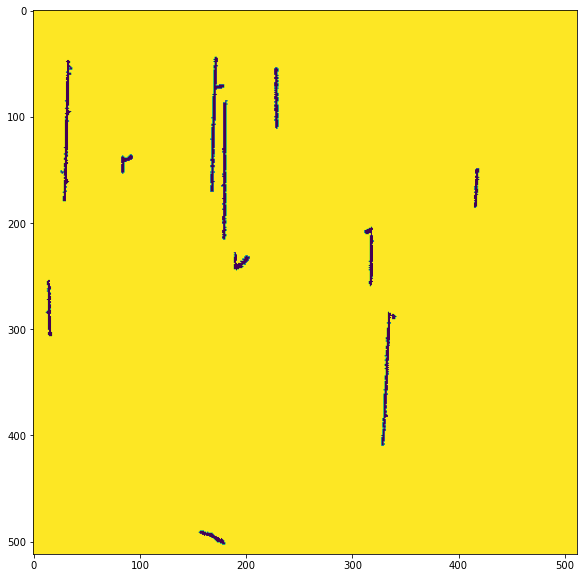

In [416]:
plt.figure(figsize = (10,10))

plt.imshow(image_label_mask)

### Detect protein on DNA

In [417]:
path = '/Users/szalapak/Projects/IMPRS_PhdCourse_2021/microscopy_files/C1-100nM_Sox2_Cherry_0_2nM_Sox2_GFP_OxScv_ShutClos20_488_003_protein.tif'

protein_frames = pims.open(path)

Frame([[221, 228, 166, ..., 150, 139, 154],
       [215, 176, 218, ..., 172, 164, 158],
       [173, 156, 212, ..., 141, 176, 164],
       ...,
       [150, 148, 132, ..., 152, 122, 152],
       [140, 114, 152, ..., 195, 119, 135],
       [138, 172, 168, ..., 117, 133, 163]], dtype=uint16)
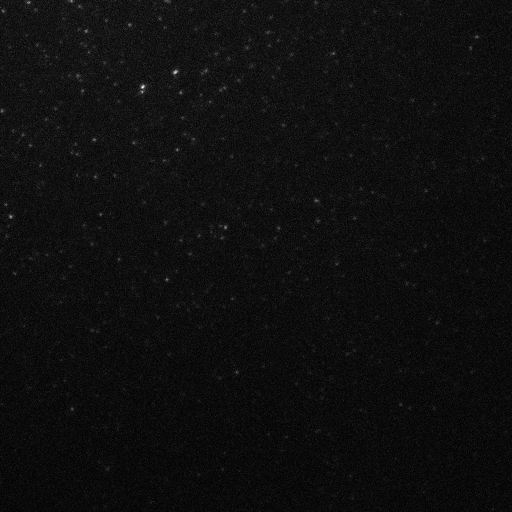

In [419]:
image = protein_frames[0]

In [430]:
global_thresh = threshold_mean(image)
binary_mean = image > global_thresh

yen_thresh = threshold_yen(image)
binary_yen = image > yen_thresh

li_thresh = threshold_li(image)
binary_li = image > li_thresh

triangle_thresh = threshold_triangle(image)
binary_triangle = image > triangle_thresh

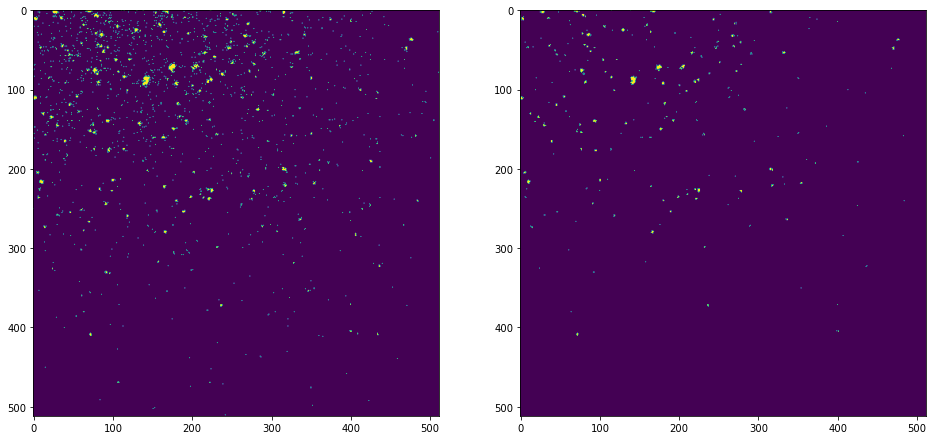

In [434]:
fig, axs = plt.subplots(1,2, figsize = (16, 8))


axs[0].imshow(binary_triangle)
axs[1].imshow(binary_yen)

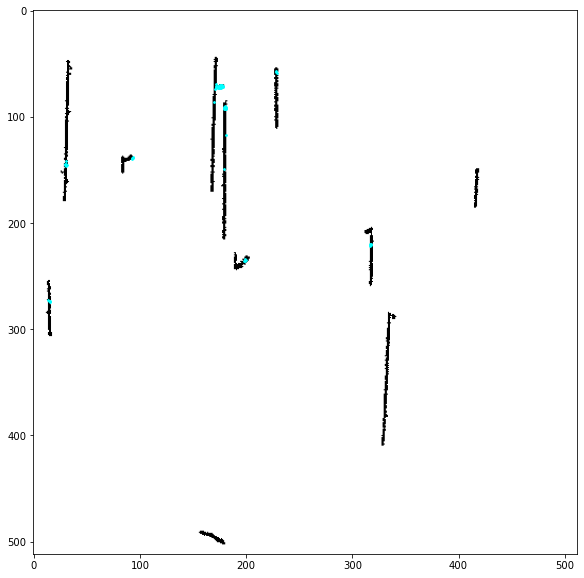

In [507]:
protein_on_DNA = (image_label_mask < dummy_number) & (np.array(binary_yen))
x_prot, y_prot = np.where(protein_on_DNA)

SM_mask = np.ma.masked_where(protein_on_DNA == False, protein_on_DNA)

plt.figure(figsize = (10,10))

plt.imshow(image_label_mask, cmap = 'gray')

plt.imshow(SM_mask, cmap = 'cool')

plt.scatter(y_prot, x_prot, c = 'cyan', s = 3)